<a href="https://colab.research.google.com/github/SriNithin965/project-4-2/blob/main/code/MERGED_ALL_MODELS_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Packages Installing



In [ ]:
!pip install pandas==1.2.0
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 3.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 2.5 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


Errors calculating fuction
* Mean Absolute Percentage Error
* Mean Error
* Mean Absolute Error
* Mean Percentage Error
* Root Mean Square Error

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE 
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, })

Packages Importing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import xgboost as xg

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data Loading

In [ ]:
data = pd.read_excel('https://github.com/SriNithin965/project-4-2/raw/main/data/Sample-Superstore.xls')

<h1>Forecasting with ARIMA</h1>

<h1> ABOUT ARIMA </h1>

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

<ul>
<li>
AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
</li>
<li>
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
</li>
<li>
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
</li>
</ul>

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:
<ul>
<li>

p: The number of lag observations included in the model, also called the lag order.
</li>
<li>
d: The number of times that the raw observations are differenced, also called the degree of differencing.
</li>
<li>
q: The size of the moving average window, also called the order of moving average.
</li>
</ul>

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

<h1>ALGORITHM FOR ARIMA MODEL FORECASTING AS FOLLOWS </h1>
<ul>
<li> STEP-1: DATA LOADING </li>
<li> STEP-2: DATA PREPROCESSING </li>
<li> STEP-3: HYPER PARAMETER INTIALIZATION </li>
<li> STEP-4: APPLYING GRID SEARCH </li>
<li> STEP-5: MODEL BUILDING AND FITTING THE DATA </li>
<li> STEP-6: MODEL FUTURE PREDICTION </li>
</ul>




*GROUPING THE DATA AND FILLING THE EMPTY VALUES BY MEDIAN*

In [ ]:
data_arima = data[['Ship Date','Sales']]
data_arima = data_arima.groupby('Ship Date').sum()
data_arima = data_arima.resample('MS').median()
data_arima.head(10)

Sales
Ship Date          
2014-01-01  149.950
2014-02-01  112.411
2014-03-01  483.546
2014-04-01  680.252
2014-05-01  504.828
2014-06-01  656.066
2014-07-01  504.586
2014-08-01  884.666
2014-09-01  947.648
2014-10-01  672.993

Normalization with min logic

In [ ]:
data_arima['Sales'] = data_arima['Sales']/min(data_arima['Sales'])

*Data  line PLOT*

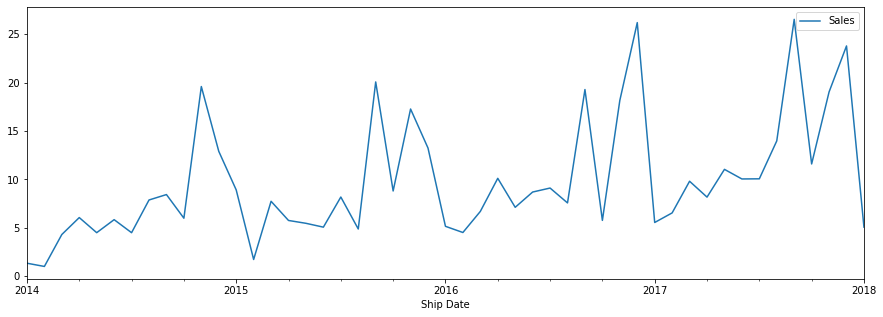

In [ ]:
data_arima.plot(figsize=(15,5))
plt.show()

*INTIALING THE HYPER PARAMETERS*

In [ ]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [ ]:
seasons = 12
seasonal_pdq = [   (x[0],x[1],x[2], seasons)  for x in pdq] 
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

*APPLYING GRID SEARCH AND LOOPING OVER MODELS  TO FIND BETTER HYPERPARAMETERS *

In [ ]:
min_pdq = (999,999,999)
min_spdq = (999,999,999,12)
min_AIC = 999
for param in pdq:
  for sparam in seasonal_pdq:
    try:
      model_arima = sm.tsa.statespace.SARIMAX(data_arima, order=param, seasonal_order=sparam, enforce_stationarity=False)
      predictions = model_arima.fit()
      if(predictions.aic < min_AIC):
        min_pdq = param
        min_spdq = sparam
        min_AIC = predictions.aic
    except Exception as e:
      print(e)
      continue

print('**** Smallest PDQ,SPDQ is *****')
print(min_AIC)
print(min_pdq)
print(min_spdq)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:887: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
maxlag should be < nobs
**** Smallest PDQ,SPDQ is *****
127.11442363600139
(1, 1, 1)
(1, 1, 0, 12)


*HERE THE MODEL BULIDING AND FITTING*

In [ ]:
model_arima = sm.tsa.statespace.SARIMAX(data_arima, order=min_pdq, seasonal_order= min_spdq, enforce_stationarity=False)
results_arima = model_arima.fit()

In [ ]:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   49
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -59.557
Date:                            Sat, 18 Jun 2022   AIC                            127.114
Time:                                    13:13:02   BIC                            131.656
Sample:                                01-01-2014   HQIC                           128.257
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4363      0.263     -1.658      0.097      -0.952       0.079
ma.L1         -0.9436      0.290     -3.250      0.001      -1.513      -0.375
ar.S.L12      -0.6368      0.199     -3.206      0.001      -1.026      -0.247
sigma2         9.5923      2.882      3.329      0.001       3.945      15.240
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 5.26
Prob(Q):                               nan   Prob(JB):                         0.07
Heteroskedasticity (H):               3.49   Skew:                             0.98
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*HERE THE PREDICTIONS*

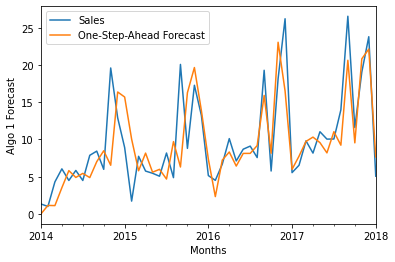

In [ ]:
pred = results_arima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = data_arima['2014':].plot(label='actual')
pred.predicted_mean.plot(ax=ax, label='One-Step-Ahead Forecast')
ax.set_xlabel('Months')
ax.set_ylabel('Algo 1 Forecast')
plt.legend()
plt.show()

Calculating the error

In [ ]:
arr = data_arima['Sales'].values
ac = pred.predicted_mean.values

In [ ]:
forecast_accuracy(ac,arr)

{'mae': 2.9545745541856703,
 'mape': 0.40265798936023695,
 'me': -0.37951624544122137,
 'mpe': 0.09628837039933469,
 'rmse': 4.223695163446492}

Future prediction (20 days)

In [ ]:
data2_arima = data_arima.copy()
import datetime
from dateutil.relativedelta import relativedelta
start = datetime.datetime.strptime("2018-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,21)]
future_prediction = pd.DataFrame(index=date_list, columns= data_arima.columns)
data2_arima = pd.concat([data2_arima, future_prediction])

In [ ]:
data2_arima

Sales
2014-01-01  1.333944
2014-02-01  1.000000
2014-03-01  4.301590
2014-04-01  6.051472
2014-05-01  4.490913
...              ...
2019-05-01       NaN
2019-06-01       NaN
2019-07-01       NaN
2019-08-01       NaN
2019-09-01       NaN

[70 rows x 1 columns]

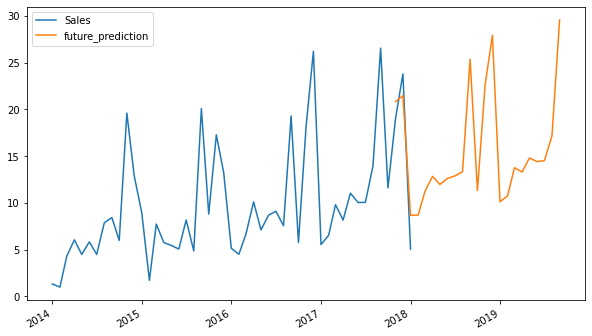

In [ ]:
data2_arima['future_prediction']=results_arima.predict(start=46, end=71 ,dynamic=True)
data2_arima[['Sales','future_prediction']].plot(figsize=(10, 6))
plt.show()

In [ ]:
data2_arima.tail(20)

Sales  future_prediction
2018-02-01    NaN           8.693579
2018-03-01    NaN          11.245522
2018-04-01    NaN          12.839374
2018-05-01    NaN          11.968523
2018-06-01    NaN          12.615123
2018-07-01    NaN          12.882561
2018-08-01    NaN          13.327140
2018-09-01    NaN          25.353270
2018-10-01    NaN          11.312223
2018-11-01    NaN          22.561998
2018-12-01    NaN          27.916468
2019-01-01    NaN          10.116971
2019-02-01    NaN          10.750720
2019-03-01    NaN          13.761415
2019-04-01    NaN          13.296194
2019-05-01    NaN          14.806712
2019-06-01    NaN          14.409622
2019-07-01    NaN          14.516171
2019-08-01    NaN          17.173013
2019-09-01    NaN          29.542122

<h1>Forecasting with LSTM</h1>

<h1>ABOUT LSTM</h1>
It is special kind of recurrent neural network that is capable of learning long term dependencies in data. This is achieved because the recurring module of the model has a combination of four layers interacting with each other.

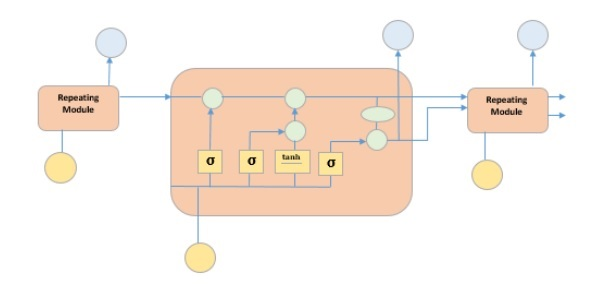

Neural Network
The picture above depicts four neural network layers in yellow boxes, point wise operators in green circles, input in yellow circles and cell state in blue circles. An LSTM module has a cell state and three gates which provides them with the power to selectively learn, unlearn or retain information from each of the units. The cell state in LSTM helps the information to flow through the units without being altered by allowing only a few linear interactions. Each unit has an input, output and a forget gate which can add or remove the information to the cell state. The forget gate decides which information from the previous cell state should be forgotten for which it uses a sigmoid function. The input gate controls the information flow to the current cell state using a point-wise multiplication operation of ‘sigmoid’ and ‘tanh’ respectively. Finally, the output gate decides which information should be passed on to the next hidden state

<h1>ALGORITHM FOR LSTM MODEL FORECASTING AS FOLLOWS </h1>
<ul>
<li> STEP-1: DATA LOADING </li>
<li> STEP-2: DATA PREPROCESSING </li>
<li> STEP-3: WINDOW PREPARATION </li>
<li> STEP-4: SPLITING THE DATA </li>
<li> STEP-5: MODEL BUILDING AND FITTING THE DATA </li>
<li> STEP-6: MODEL FUTURE PREDICTION </li>
</ul>

Data Preparation

In [ ]:
data_lstm = data[['Ship Date','Sales']]
data_lstm = data_lstm.groupby('Ship Date').sum()
data_lstm = data_lstm.resample('MS').median()
data_lstm.head(10)

Sales
Ship Date          
2014-01-01  149.950
2014-02-01  112.411
2014-03-01  483.546
2014-04-01  680.252
2014-05-01  504.828
2014-06-01  656.066
2014-07-01  504.586
2014-08-01  884.666
2014-09-01  947.648
2014-10-01  672.993

In [ ]:
num_lstm = data_lstm.values

Normalization with min concept

In [ ]:
num1_lstm = num_lstm/min(num_lstm)
num1_lstm

array([[ 1.33394419],
       [ 1.        ],
       [ 4.3015897 ],
       [ 6.05147183],
       [ 4.49091281],
       [ 5.83631495],
       [ 4.48876   ],
       [ 7.86992376],
       [ 8.43020701],
       [ 5.9868963 ],
       [19.59643184],
       [12.90169112],
       [ 8.91275765],
       [ 1.71976052],
       [ 7.73563975],
       [ 5.7530046 ],
       [ 5.45941234],
       [ 5.06175552],
       [ 8.17637954],
       [ 4.87140938],
       [20.07292881],
       [ 8.80189661],
       [17.27444823],
       [13.23658717],
       [ 5.14900677],
       [ 4.50911388],
       [ 6.68817553],
       [10.10991807],
       [ 7.11310281],
       [ 8.69147148],
       [ 9.10441149],
       [ 7.56666163],
       [19.28581722],
       [ 5.76150021],
       [18.16295113],
       [26.20554038],
       [ 5.54403484],
       [ 6.53475194],
       [ 9.80712742],
       [ 8.16737686],
       [11.03626869],
       [10.04383913],
       [10.05861526],
       [13.97736876],
       [26.54211776],
       [11

Function to generate a window of numbers which goes as input to the model

* [n1,n2.n3] --> input 
* n4 --> output

In [ ]:
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		end_ix = i + n_features
		if end_ix > len(timeseries_data)-1:
			break
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

Generating the window

In [ ]:
n_steps = 3
X_lstm, y_lstm = prepare_data(num1_lstm, n_steps)

In [ ]:
print(X_lstm),print(y_lstm)

[[[ 1.33394419]
  [ 1.        ]
  [ 4.3015897 ]]

 [[ 1.        ]
  [ 4.3015897 ]
  [ 6.05147183]]

 [[ 4.3015897 ]
  [ 6.05147183]
  [ 4.49091281]]

 [[ 6.05147183]
  [ 4.49091281]
  [ 5.83631495]]

 [[ 4.49091281]
  [ 5.83631495]
  [ 4.48876   ]]

 [[ 5.83631495]
  [ 4.48876   ]
  [ 7.86992376]]

 [[ 4.48876   ]
  [ 7.86992376]
  [ 8.43020701]]

 [[ 7.86992376]
  [ 8.43020701]
  [ 5.9868963 ]]

 [[ 8.43020701]
  [ 5.9868963 ]
  [19.59643184]]

 [[ 5.9868963 ]
  [19.59643184]
  [12.90169112]]

 [[19.59643184]
  [12.90169112]
  [ 8.91275765]]

 [[12.90169112]
  [ 8.91275765]
  [ 1.71976052]]

 [[ 8.91275765]
  [ 1.71976052]
  [ 7.73563975]]

 [[ 1.71976052]
  [ 7.73563975]
  [ 5.7530046 ]]

 [[ 7.73563975]
  [ 5.7530046 ]
  [ 5.45941234]]

 [[ 5.7530046 ]
  [ 5.45941234]
  [ 5.06175552]]

 [[ 5.45941234]
  [ 5.06175552]
  [ 8.17637954]]

 [[ 5.06175552]
  [ 8.17637954]
  [ 4.87140938]]

 [[ 8.17637954]
  [ 4.87140938]
  [20.07292881]]

 [[ 4.87140938]
  [20.07292881]
  [ 8.80189661]]



(None, None)

Reshaping the data 
(three dimensional)

In [ ]:
n_features = 1
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], n_features))

Model buliding and training

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_lstm.add(LSTM(50, activation='relu'))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=1)

Epoch 1/300
2/2 [==============================] - 3s 18ms/step - loss: 143.3849
Epoch 2/300
2/2 [==============================] - 0s 12ms/step - loss: 142.0688
Epoch 3/300
2/2 [==============================] - 0s 10ms/step - loss: 140.8049
Epoch 4/300
2/2 [==============================] - 0s 10ms/step - loss: 139.5039
Epoch 5/300
2/2 [==============================] - 0s 12ms/step - loss: 137.9739
Epoch 6/300
2/2 [==============================] - 0s 12ms/step - loss: 136.3788
Epoch 7/300
2/2 [==============================] - 0s 10ms/step - loss: 134.5567
Epoch 8/300
2/2 [==============================] - 0s 11ms/step - loss: 132.3414
Epoch 9/300
2/2 [==============================] - 0s 11ms/step - loss: 129.8986
Epoch 10/300
2/2 [==============================] - 0s 10ms/step - loss: 126.5204
Epoch 11/300
2/2 [==============================] - 0s 12ms/step - loss: 122.7690
Epoch 12/300
2/2 [==============================] - 0s 12ms/step - loss: 118.6904
Epoch 13/300
2/2 [=======

Prediction of existing values

In [ ]:
y_pred_lstm = model_lstm.predict(X_lstm)
y_plot_pred_lstm = y_pred_lstm.reshape(y_pred_lstm.shape[0])
y_plot_pred_lstm.shape

(46,)

In [ ]:
y_plot_present_lstm = y_lstm.reshape(y_lstm.shape[0])
y_plot_present_lstm

array([ 6.05147183,  4.49091281,  5.83631495,  4.48876   ,  7.86992376,
        8.43020701,  5.9868963 , 19.59643184, 12.90169112,  8.91275765,
        1.71976052,  7.73563975,  5.7530046 ,  5.45941234,  5.06175552,
        8.17637954,  4.87140938, 20.07292881,  8.80189661, 17.27444823,
       13.23658717,  5.14900677,  4.50911388,  6.68817553, 10.10991807,
        7.11310281,  8.69147148,  9.10441149,  7.56666163, 19.28581722,
        5.76150021, 18.16295113, 26.20554038,  5.54403484,  6.53475194,
        9.80712742,  8.16737686, 11.03626869, 10.04383913, 10.05861526,
       13.97736876, 26.54211776, 11.59498626, 19.03944454, 23.79368567,
        5.06421969])

the plot of model on data

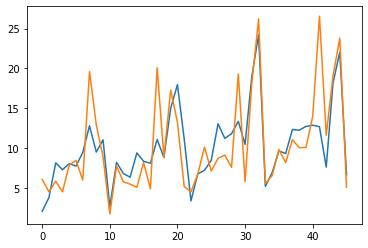

In [ ]:
plt.plot(y_plot_pred_lstm)
plt.plot(y_plot_present_lstm)
plt.show()

generating the future prediction

In [ ]:
l_lstm = []
for i in num1_lstm[-3:]:
  for j in i:
    l_lstm.append(j)

In [ ]:
x_input_lstm = np.array(l_lstm)
temp_input_lstm=list(x_input_lstm)
lst_output_lstm=[]
i=0
while(i<20):
    
    if(len(temp_input_lstm)>3):
        x_input_lstm=np.array(temp_input_lstm[1:])
        print("{} day input {}".format(i,x_input_lstm))
        x_input_lstm = x_input_lstm.reshape((1, n_steps, n_features))
        yhat_lstm = model_lstm.predict(x_input_lstm, verbose=0)
        print("{} day output {}".format(i,yhat_lstm))
        temp_input_lstm.append(yhat_lstm[0][0])
        temp_input_lstm=temp_input_lstm[1:]
        lst_output_lstm.append(yhat_lstm[0][0])
        i=i+1
    else:
        x_input_lstm = x_input_lstm.reshape((1, n_steps, n_features))
        yhat_lstm = model_lstm.predict(x_input_lstm, verbose=0)
        print(yhat_lstm[0])
        temp_input_lstm.append(yhat_lstm[0][0])
        lst_output_lstm.append(yhat_lstm[0][0])
        i=i+1
    

print(lst_output_lstm)

[3.0791526]
1 day input [23.79368567  5.06421969  3.07915258]
1 day output [[6.4633207]]
2 day input [5.06421969 3.07915258 6.46332073]
2 day output [[5.788712]]
3 day input [3.0791526 6.4633207 5.788712 ]
3 day output [[7.351319]]
4 day input [6.4633207 5.788712  7.351319 ]
4 day output [[9.062919]]
5 day input [5.788712 7.351319 9.062919]
5 day output [[10.144855]]
6 day input [ 7.351319  9.062919 10.144855]
6 day output [[12.040603]]
7 day input [ 9.062919 10.144855 12.040603]
7 day output [[12.602695]]
8 day input [10.144855 12.040603 12.602695]
8 day output [[12.521772]]
9 day input [12.040603 12.602695 12.521772]
9 day output [[12.12351]]
10 day input [12.602695 12.521772 12.12351 ]
10 day output [[11.900086]]
11 day input [12.521772 12.12351  11.900086]
11 day output [[11.996375]]
12 day input [12.12351  11.900086 11.996375]
12 day output [[12.206756]]
13 day input [11.900086 11.996375 12.206756]
13 day output [[12.276006]]
14 day input [11.996375 12.206756 12.276006]
14 day out

Merging the data prediction and future prediction

In [ ]:
l2_lstm = []
for i in y_plot_pred_lstm:
  l2_lstm.append(i)
print(l2_lstm)

[2.0418491, 3.763698, 8.13073, 7.271722, 8.024722, 7.7295594, 9.438756, 12.791359, 9.486391, 11.028235, 2.6206253, 8.195791, 6.797351, 6.3328257, 9.37774, 8.323857, 8.0839405, 11.066071, 8.80492, 14.985172, 17.95626, 11.120548, 3.3549023, 6.741272, 7.193091, 8.451723, 13.039675, 11.204195, 11.797979, 13.344876, 10.44486, 19.00315, 24.200752, 5.1826663, 6.900378, 9.631315, 9.303436, 12.318289, 12.234115, 12.707474, 12.861305, 12.668665, 7.588973, 18.160873, 22.01368, 6.6287446]


In [ ]:
for i in lst_output_lstm:
  l2_lstm.append(i)

plot of data and merged prediction

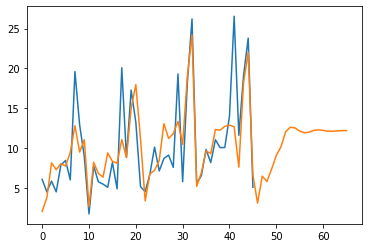

In [ ]:
plt.plot(y_plot_present_lstm)
plt.plot(l2_lstm)
plt.show()

In [ ]:
date_lstm = pd.date_range(start='2018-02-01',end='2019-09-01', freq='MS')
lst_output_data_lstm = lst_output_lstm*min(num_lstm)

here the future predictions

In [ ]:
data3_lstm = pd.DataFrame(date_lstm,lst_output_lstm*min(num_lstm))
data3_lstm

0
346.130621  2018-02-01
726.548347  2018-03-01
650.714907  2018-04-01
826.369102  2018-05-01
1018.771750 2018-06-01
1140.393244 2018-07-01
1353.496188 2018-08-01
1416.681600 2018-09-01
1407.584956 2018-10-01
1362.815923 2018-11-01
1337.700613 2018-12-01
1348.524520 2019-01-01
1372.173608 2019-02-01
1379.958082 2019-03-01
1372.191404 2019-04-01
1361.910697 2019-05-01
1359.867506 2019-06-01
1364.718785 2019-07-01
1369.182416 2019-08-01
1369.209110 2019-09-01

<h1>Forecasting with XGBOOST</h1>

<h1> ABOUT XGBOOST </h1>

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now. Please see the chart below for the evolution of tree-based algorithms over the years.

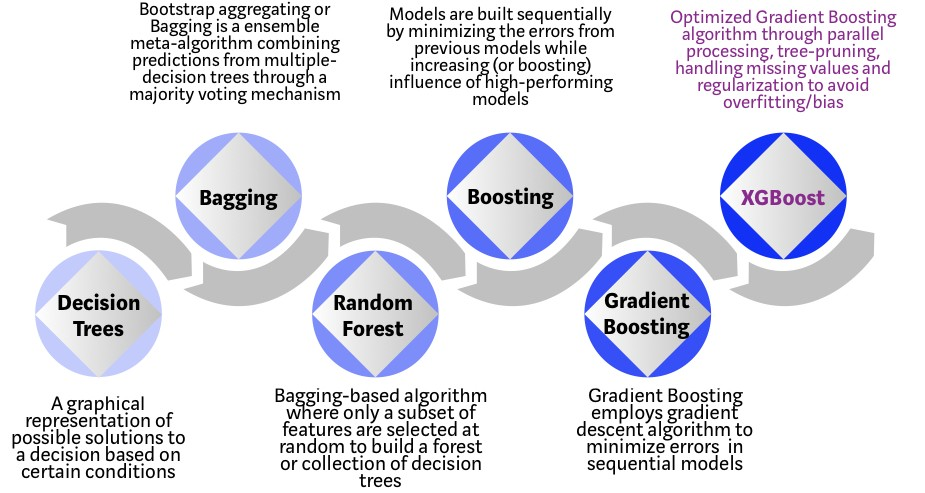

Evolution of XGBoost Algorithm from Decision Trees
XGBoost algorithm was developed as a research project at the University of Washington. Tianqi Chen and Carlos Guestrin presented their paper at SIGKDD Conference in 2016 and caught the Machine Learning world by fire. Since its introduction, this algorithm has not only been credited with winning numerous Kaggle competitions but also for being the driving force under the hood for several cutting-edge industry applications. As a result, there is a strong community of data scientists contributing to the XGBoost open source projects with ~350 contributors and ~3,600 commits on GitHub. The algorithm differentiates itself in the following ways:

A wide range of applications: Can be used to solve regression, classification, ranking, and user-defined prediction problems.

Portability: Runs smoothly on Windows, Linux, and OS X. <br>
Languages: Supports all major programming languages including C++, Python, R, Java, Scala, and Julia.
<br>
Cloud Integration: Supports AWS, Azure, and Yarn clusters and works well with Flink, Spark, and other ecosystems.


<h1>ALGORITHM FOR XGBOOST MODEL FORECASTING AS FOLLOWS </h1>
<ul>
<li> STEP-1: DATA LOADING </li>
<li> STEP-2: DATA PREPROCESSING </li>
<li> STEP-3: WINDOW PREPARATION </li>
<li> STEP-4: SPLITING THE DATA </li>
<li> STEP-5: MODEL BUILDING AND FITTING THE DATA </li>
<li> STEP-6: MODEL FUTURE PREDICTION </li>
</ul>

Data Preparation

In [ ]:
data_xg = data[['Ship Date','Sales']]
data_xg = data_xg.groupby('Ship Date').sum()
data_xg = data_xg.resample('MS').median()
data_xg.head(10)

Sales
Ship Date          
2014-01-01  149.950
2014-02-01  112.411
2014-03-01  483.546
2014-04-01  680.252
2014-05-01  504.828
2014-06-01  656.066
2014-07-01  504.586
2014-08-01  884.666
2014-09-01  947.648
2014-10-01  672.993

In [ ]:
num_xg = data_xg.values

Normalization with min logic

In [ ]:
num1_xg = num_xg/min(num_xg)
num1_xg

array([[ 1.33394419],
       [ 1.        ],
       [ 4.3015897 ],
       [ 6.05147183],
       [ 4.49091281],
       [ 5.83631495],
       [ 4.48876   ],
       [ 7.86992376],
       [ 8.43020701],
       [ 5.9868963 ],
       [19.59643184],
       [12.90169112],
       [ 8.91275765],
       [ 1.71976052],
       [ 7.73563975],
       [ 5.7530046 ],
       [ 5.45941234],
       [ 5.06175552],
       [ 8.17637954],
       [ 4.87140938],
       [20.07292881],
       [ 8.80189661],
       [17.27444823],
       [13.23658717],
       [ 5.14900677],
       [ 4.50911388],
       [ 6.68817553],
       [10.10991807],
       [ 7.11310281],
       [ 8.69147148],
       [ 9.10441149],
       [ 7.56666163],
       [19.28581722],
       [ 5.76150021],
       [18.16295113],
       [26.20554038],
       [ 5.54403484],
       [ 6.53475194],
       [ 9.80712742],
       [ 8.16737686],
       [11.03626869],
       [10.04383913],
       [10.05861526],
       [13.97736876],
       [26.54211776],
       [11

Function to generate a window of numbers which goes as input to the model

* [n1,n2.n3] --> input 
* n4 --> output

In [ ]:
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		end_ix = i + n_features
		if end_ix > len(timeseries_data)-1:
			break
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

generating the window

In [ ]:
n_steps = 3
X_xg, y_xg = prepare_data(num1_xg, n_steps)

In [ ]:
print(X_xg),print(y_xg)

[[[ 1.33394419]
  [ 1.        ]
  [ 4.3015897 ]]

 [[ 1.        ]
  [ 4.3015897 ]
  [ 6.05147183]]

 [[ 4.3015897 ]
  [ 6.05147183]
  [ 4.49091281]]

 [[ 6.05147183]
  [ 4.49091281]
  [ 5.83631495]]

 [[ 4.49091281]
  [ 5.83631495]
  [ 4.48876   ]]

 [[ 5.83631495]
  [ 4.48876   ]
  [ 7.86992376]]

 [[ 4.48876   ]
  [ 7.86992376]
  [ 8.43020701]]

 [[ 7.86992376]
  [ 8.43020701]
  [ 5.9868963 ]]

 [[ 8.43020701]
  [ 5.9868963 ]
  [19.59643184]]

 [[ 5.9868963 ]
  [19.59643184]
  [12.90169112]]

 [[19.59643184]
  [12.90169112]
  [ 8.91275765]]

 [[12.90169112]
  [ 8.91275765]
  [ 1.71976052]]

 [[ 8.91275765]
  [ 1.71976052]
  [ 7.73563975]]

 [[ 1.71976052]
  [ 7.73563975]
  [ 5.7530046 ]]

 [[ 7.73563975]
  [ 5.7530046 ]
  [ 5.45941234]]

 [[ 5.7530046 ]
  [ 5.45941234]
  [ 5.06175552]]

 [[ 5.45941234]
  [ 5.06175552]
  [ 8.17637954]]

 [[ 5.06175552]
  [ 8.17637954]
  [ 4.87140938]]

 [[ 8.17637954]
  [ 4.87140938]
  [20.07292881]]

 [[ 4.87140938]
  [20.07292881]
  [ 8.80189661]]



(None, None)

reshaping the data

In [ ]:
X_xg = X_xg.reshape((X_xg.shape[0], X_xg.shape[1]))
y_xg = y_xg.reshape(y_xg.shape[0])

Model buliding and training

In [ ]:
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 100, seed = 123)

In [ ]:
xgb_r.fit(X_xg, y_xg)

[13:13:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(seed=123)

Prediction on data

In [ ]:
y_pred_xg = xgb_r.predict(X_xg)

ploting the data and predicted data

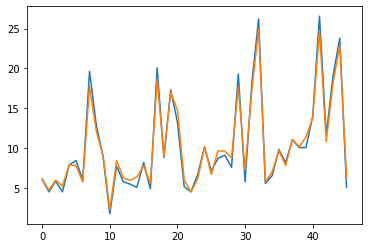

In [ ]:
plt.plot(y_xg)
plt.plot(y_pred_xg)
plt.show()

Metrics finding

In [ ]:
forecast_accuracy(y_pred_xg,y_xg)

{'mae': 0.6810354720454652,
 'mape': 0.08009794609755747,
 'me': 0.00017894574120746537,
 'mpe': 0.03456499804466155,
 'rmse': 0.8564860845417669}

making the future predictions

In [ ]:
l_xg = []
for i in num1_xg[-3:]:
  for j in i:
    l_xg.append(j)

In [ ]:
l_xg

[19.039444538345894, 23.793685671331094, 5.064219693802208]

In [ ]:
x_input_xg = np.array(l_xg)
temp_input_xg=list(x_input_xg)
lst_output_xg=[]
i=0
while(i<20):
    
    if(len(temp_input_xg)>3):
        x_input_xg=np.array(temp_input_xg[1:])
        print("{} day input {}".format(i,x_input_xg))
        x_input_xg = x_input_xg.reshape(1,3)
        yhat_xg = xgb_r.predict(x_input_xg)
        print("{} day output {}".format(i,yhat_xg))
        temp_input_xg.append(yhat_xg[0])
        temp_input_xg=temp_input_xg[1:]
        lst_output_xg.append(yhat_xg[0])
        i=i+1
    else:
        x_input_xg = x_input_xg.reshape(1,3)
        yhat_xg = xgb_r.predict(x_input_xg)
        print(yhat_xg[0])
        temp_input_xg.append(yhat_xg[0])
        lst_output_xg.append(yhat_xg[0])
        i=i+1
    

print(lst_output_xg)

8.496529
1 day input [23.79368567  5.06421969  8.49652863]
1 day output [7.443159]
2 day input [5.06421969 8.49652863 7.4431591 ]
2 day output [18.544426]
3 day input [ 8.496529  7.443159 18.544426]
3 day output [21.716692]
4 day input [ 7.443159 18.544426 21.716692]
4 day output [7.2125797]
5 day input [18.544426  21.716692   7.2125797]
5 day output [9.636567]
6 day input [21.716692   7.2125797  9.636567 ]
6 day output [7.0302806]
7 day input [7.2125797 9.636567  7.0302806]
7 day output [12.165063]
8 day input [ 9.636567   7.0302806 12.165063 ]
8 day output [11.6622095]
9 day input [ 7.0302806 12.165063  11.6622095]
9 day output [6.938306]
10 day input [12.165063  11.6622095  6.938306 ]
10 day output [10.40269]
11 day input [11.6622095  6.938306  10.40269  ]
11 day output [9.73619]
12 day input [ 6.938306 10.40269   9.73619 ]
12 day output [7.6470613]
13 day input [10.40269    9.73619    7.6470613]
13 day output [15.205476]
14 day input [ 9.73619    7.6470613 15.205476 ]
14 day output

Appending the predicted data with future predicted data

In [ ]:
l2_xg = []
for i in y_pred_xg:
  l2_xg.append(i)
print(l2_xg)

[6.087861, 4.702067, 5.9602304, 5.21722, 7.915592, 7.774254, 5.7204027, 17.715523, 12.118702, 9.082234, 2.270389, 8.417998, 6.2606616, 5.9412074, 6.359717, 7.7591677, 5.6020236, 18.612713, 8.953306, 16.982737, 14.775322, 6.0134473, 4.452443, 6.163789, 10.156446, 6.683559, 9.651969, 9.579707, 8.773639, 17.65734, 7.2329125, 17.263914, 24.93476, 5.7651825, 6.9930544, 9.665568, 7.8029943, 11.091879, 10.147011, 11.358931, 13.766332, 24.76202, 10.828839, 18.131838, 22.869198, 6.3122296]


In [ ]:
for i in lst_output_xg:
  l2_xg.append(i)

here the plot of data merged predictions

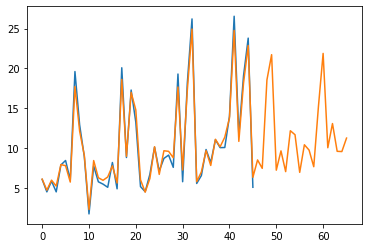

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_xg)
plt.plot(l2_xg)
plt.show()

Here the prediction values

In [ ]:
date_xg = pd.date_range(start='2018-02-01',end='2019-09-01', freq='MS')
lst_output_data_xg = lst_output_xg*min(num_xg)

In [ ]:
data3_xg = pd.DataFrame(date_xg,lst_output_xg*min(num_xg))
data3_xg

0
955.103279  2018-02-01
836.692958  2018-03-01
2084.597467 2018-04-01
2441.195061 2018-05-01
810.773300  2018-06-01
1083.256146 2018-07-01
790.280871  2018-08-01
1367.486886 2018-09-01
1310.960633 2018-10-01
779.941899  2018-11-01
1169.376778 2018-12-01
1094.454836 2019-01-01
859.613813  2019-02-01
1709.262741 2019-03-01
2459.074673 2019-04-01
1127.472759 2019-05-01
1468.737789 2019-06-01
1077.080368 2019-07-01
1073.433734 2019-08-01
1263.565116 2019-09-01

making the metrics data frames

In [ ]:
dict_arima = forecast_accuracy(ac,arr)
dict_lstm = forecast_accuracy(y_pred_lstm,y_lstm)
dict_xg = forecast_accuracy(y_pred_xg,y_xg)

In [ ]:
data_m = pd.DataFrame({'Arima':pd.Series(dict_arima),'Lstm':pd.Series(dict_lstm),'Xgboost':pd.Series(dict_xg)})
data_m

Arima      Lstm   Xgboost
mape  0.402658  0.292332  0.080098
me   -0.379516 -0.041991  0.000179
mae   2.954575  2.617229  0.681035
mpe   0.096288  0.110507  0.034565
rmse  4.223695  3.690898  0.856486

here the bar plot of metrics

(-1.0, 5.0)

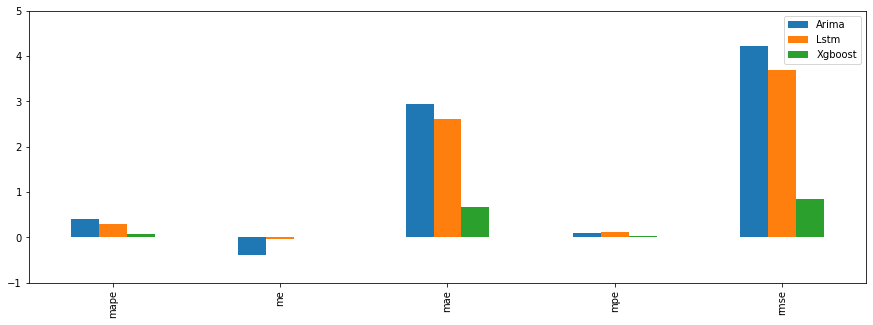

In [ ]:
ax = data_m.plot(kind='bar',figsize=(15,5))
ax.set_ylim(-1,5)

dataframes of future preditions of all three models

In [ ]:
data_mer_lstm= data3_lstm.reset_index()
data_mer_xg = data3_xg.reset_index()

In [ ]:
data_mer_lstm = data_mer_lstm.set_index(0)
data_mer_lstm

index
0                      
2018-02-01   346.130621
2018-03-01   726.548347
2018-04-01   650.714907
2018-05-01   826.369102
2018-06-01  1018.771750
2018-07-01  1140.393244
2018-08-01  1353.496188
2018-09-01  1416.681600
2018-10-01  1407.584956
2018-11-01  1362.815923
2018-12-01  1337.700613
2019-01-01  1348.524520
2019-02-01  1372.173608
2019-03-01  1379.958082
2019-04-01  1372.191404
2019-05-01  1361.910697
2019-06-01  1359.867506
2019-07-01  1364.718785
2019-08-01  1369.182416
2019-09-01  1369.209110

In [ ]:
data_mer_xg = data_mer_xg.set_index(0)
data_mer_xg

index
0                      
2018-02-01   955.103279
2018-03-01   836.692958
2018-04-01  2084.597467
2018-05-01  2441.195061
2018-06-01   810.773300
2018-07-01  1083.256146
2018-08-01   790.280871
2018-09-01  1367.486886
2018-10-01  1310.960633
2018-11-01   779.941899
2018-12-01  1169.376778
2019-01-01  1094.454836
2019-02-01   859.613813
2019-03-01  1709.262741
2019-04-01  2459.074673
2019-05-01  1127.472759
2019-06-01  1468.737789
2019-07-01  1077.080368
2019-08-01  1073.433734
2019-09-01  1263.565116

In [ ]:
data_arima = data[['Ship Date','Sales']]
data_arima = data_arima.groupby('Ship Date').sum()
data_arima = data_arima.resample('MS').median()

here merged dataframe of future preditions

In [ ]:
merged = data2_arima.copy()
merged['Lstm'] = data_mer_lstm
merged['xgboost'] = data_mer_xg
merged['Arima'] = merged['future_prediction']*min(data_arima['Sales'].values)
merged = merged.drop('future_prediction',axis=1)
merged = merged.drop('Sales',axis=1)
merged.tail(20)

Lstm      xgboost        Arima
2018-02-01   346.130621   955.103279   977.253958
2018-03-01   726.548347   836.692958  1264.120396
2018-04-01   650.714907  2084.597467  1443.286816
2018-05-01   826.369102  2441.195061  1345.393602
2018-06-01  1018.771750   810.773300  1418.078625
2018-07-01  1140.393244  1083.256146  1448.141587
2018-08-01  1353.496188   790.280871  1498.117151
2018-09-01  1416.681600  1367.486886  2849.986462
2018-10-01  1407.584956  1310.960633  1271.618252
2018-11-01  1362.815923   779.941899  2536.216714
2018-12-01  1337.700613  1169.376778  3138.118135
2019-01-01  1348.524520  1094.454836  1137.258805
2019-02-01  1372.173608   859.613813  1208.499224
2019-03-01  1379.958082  1709.262741  1546.934372
2019-04-01  1372.191404  2459.074673  1494.638433
2019-05-01  1361.910697  1127.472759  1664.437355
2019-06-01  1359.867506  1468.737789  1619.800003
2019-07-01  1364.718785  1077.080368  1631.777337
2019-08-01  1369.182416  1073.433734  1930.435601
2019-09-01  1369.209110  1263.565116  3320.859450

making of dataframe of  prediction on existing data by three models

In [ ]:
v = min(data_arima['Sales'])

In [ ]:
y_pred_xg_org = list(y_pred_xg) + lst_output_xg[0:3]
y_pred_lstm_org = list(y_pred_lstm) +lst_output_lstm[0:3]
y_pred_xg_org =  [i*v for i in y_pred_xg_org]
y_pred_lstm_org = [i*v for i in y_pred_lstm_org]

here mreged data frame

In [ ]:
org = pred.predicted_mean*min(data_arima['Sales'])
org = pd.DataFrame(org)
org['Arima'] = org.values
org['Sales'] = data_arima['Sales']
org['Lstm'] = y_pred_lstm_org
org['Xgboost'] = y_pred_xg_org
org = org.drop(0,axis=1)
org

Arima      Sales         Lstm      Xgboost
Ship Date                                                   
2014-01-01     0.000000   149.9500   [229.5263]   684.342550
2014-02-01   128.141060   112.4110   [423.0811]   528.564042
2014-03-01   125.563333   483.5460  [913.98346]   669.995454
2014-04-01   395.956977   680.2520   [817.4216]   586.472898
2014-05-01   653.498250   504.8280   [902.0671]   889.799634
2014-06-01   550.476752   656.0660   [868.8875]   873.911649
2014-07-01   612.018174   504.5860    [1061.02]   643.036190
2014-08-01   548.356463   884.6660  [1437.8895]  1991.419630
2014-09-01   788.711523   947.6480  [1066.3748]  1362.275403
2014-10-01   953.193727   672.9930  [1239.6951]  1020.943049
2014-11-01   734.607157  2202.8545  [294.58713]   255.216707
2014-12-01  1840.434174  1450.2920   [921.2971]   946.275608
2015-01-01  1764.296416  1001.8920  [764.09705]   703.767231
2015-02-01  1128.436202   193.3200   [711.8793]   667.857066
2015-03-01   651.317690   869.5710  [1054.1611]   714.902136
2015-04-01   917.809124   646.7010   [935.6932]   872.215797
2015-05-01   629.568898   613.6980   [908.7239]   629.729075
2015-06-01   673.102053   568.9970  [1243.9481]  2092.273665
2015-07-01   526.641162   919.1150   [989.7699]  1006.450103
2015-08-01  1091.399472   547.6000  [1684.4983]  1909.046403
2015-09-01   708.326174  2256.4180  [2018.4813]  1660.908717
2015-10-01  1830.080409   989.4300   [1250.072]   675.977623
2015-11-01  2209.326598  1941.8380  [377.12793]   500.503584
2015-12-01  1560.140965  1487.9380  [757.79315]   692.877662
2016-01-01   826.315823   578.8050   [808.5826]  1141.696303
2016-02-01   261.217827   506.8740  [950.06665]   751.305544
2016-03-01   812.484516   751.8245   [1465.803]  1084.987482
2016-04-01   934.772773  1136.4660  [1259.4749]  1076.864460
2016-05-01   722.497503   799.5910  [1326.2227]   986.253503
2016-06-01   913.392126   977.0170   [1500.111]  1984.879145
2016-07-01   913.707327  1023.4360  [1174.1172]   813.058932
2016-08-01  1031.706711   850.5760  [2136.1633]  1940.653849
2016-09-01  1788.947693  2167.9380   [2720.431]  2802.941210
2016-10-01   915.437642   647.6560  [582.58875]   648.069929
2016-11-01  2590.934466  2041.7155  [775.67847]   786.096237
2016-12-01  1856.376276  2945.7910  [1082.6658]  1086.516204
2017-01-01   672.524778   623.2105  [1045.8086]   877.142387
2017-02-01   871.689036   734.5780  [1384.7112]  1246.849198
2017-03-01  1094.637655  1102.4290  [1375.2491]  1140.635631
2017-04-01  1159.288788   918.1030  [1428.4598]  1276.868746
2017-05-01  1076.139167  1240.5980  [1445.7522]  1547.487110
2017-06-01   921.470500  1129.0380  [1424.0973]  2783.523443
2017-07-01  1241.048531  1130.6990  [853.08405]  1217.280655
2017-08-01  1037.658079  1571.2100   [2041.482]  2038.218024
2017-09-01  2318.842893  2983.6260  [2474.5798]  2570.749399
2017-10-01  1072.610635  1303.4040  [745.14386]   709.564045
2017-11-01  2341.053568  2140.2430   346.130621   955.103279
2017-12-01  2487.631033  2674.6720   726.548347   836.692958
2018-01-01   861.168668   569.2740   650.714907  2084.597467